In [1]:
import csv

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [2]:
# 単語ベクトル化をGridSearchCVで使うのためのクラス
class myVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, method='tfidf', min_df=0.0005, max_df=0.10):
        self.method = method
        self.min_df = min_df
        self.max_df = max_df

    def fit(self, x, y=None):
        if self.method == 'tfidf':
            self.vectorizer = TfidfVectorizer(min_df=self.min_df, max_df=self.max_df)
        else:
            self.vectorizer = CountVectorizer(min_df=self.min_df, max_df=self.max_df)
        self.vectorizer.fit(x)
        return self

    def transform(self, x, y=None):
        return self.vectorizer.transform(x)

In [3]:
# GridSearchCV用パラメータ
PARAMETERS = [
    {
        'vectorizer__method':['tfidf', 'count'], 
        'vectorizer__min_df': [0.0003, 0.0004], 
        'vectorizer__max_df': [0.07, 0.10], 
        'classifier__C': [1, 3],    #10も試したが遅いだけでSCORE低い
        'classifier__solver': ['newton-cg', 'liblinear']},
    ]

# 時間がかかるので下記を省略
#        'vectorizer__min_df': [0.0003, 0.0004, 0.0005, 0.0006], 
#        'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']},

In [4]:
# ファイル読込
def read_csv_column(col):
    with open('./sentiment_stem.txt') as file:
        reader = csv.reader(file, delimiter='\t')
        header = next(reader)
        return [row[col] for row in reader]    

In [5]:
x_all = read_csv_column(1)
y_all = read_csv_column(0)
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all)

In [6]:
# 訓練
def train(x_train, y_train, file):
    pipline = Pipeline([('vectorizer', myVectorizer()), ('classifier', LogisticRegression())])
    
    # clf は classificationの略
    clf = GridSearchCV(
            pipline, # 
            PARAMETERS,           # 最適化したいパラメータセット 
            cv = 5)               # 交差検定の回数
    
    clf.fit(x_train, y_train)
    pd.DataFrame.from_dict(clf.cv_results_).to_csv(file)
    
    print('Grid Search Best parameters:', clf.best_params_)
    print('Grid Search Best validation score:', clf.best_score_)
    print('Grid Search Best training score:', clf.best_estimator_.score(x_train, y_train))
    
    # 素性の重み出力
    output_coef(clf.best_estimator_)

    return clf.best_estimator_

In [7]:
# 素性の重み出力
def output_coef(estimator):
    vec = estimator.named_steps['vectorizer']
    clf = estimator.named_steps['classifier']

    coef_df = pd.DataFrame([clf.coef_[0]]).T.rename(columns={0: 'Coefficients'})
    coef_df.index = vec.vectorizer.get_feature_names()
    coef_sort = coef_df.sort_values('Coefficients')
    coef_sort[:10].plot.barh()
    coef_sort.tail(10).plot.barh()

In [8]:
# 評価
def validate(estimator, x_test, y_test):
    
    for i, (x, y) in enumerate(zip(x_test, y_test)):
        y_pred = estimator.predict_proba([x])
        if y == np.argmax(y_pred).astype( str ):
            if y == '1':
                result = 'TP:正解がPositiveで予測もPositive'
            else:
                result = 'TN:正解がNegativeで予測もNegative'
        else:
            if y == '1':
                result = 'FN:正解がPositiveで予測はNegative'
            else:
                result = 'FP:正解がNegativeで予測はPositive'
        print(result, y_pred, x)
        if i == 9:
            break
            
    # TSV一覧出力
    # 正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．
    y_pred = estimator.predict(x_test)
    y_prob = estimator.predict_proba(x_test)

    results = pd.DataFrame([y_test, y_pred, y_prob.T[1], x_test]).T.rename(columns={ 0: '正解', 1 : '予測', 2: '予測確率(ポジティブ)', 3 :'単語列'})
    results.to_csv('./predict.txt' , sep='\t')
    
    print('\n', classification_report(y_test, y_pred))
    print('\n', confusion_matrix(y_test, y_pred))    

In [9]:
# グラフ出力
def output_graphs(estimator, x_all, y_all, x_test, y_test):
    
    # 学習曲線出力
    output_learning_curve(estimator, x_all, y_all)
    
    y_pred = estimator.predict_proba(x_test)
    
    # ROC曲線出力
    output_roc(y_test, y_pred)
    
    # 適合率-再現率グラフ出力
    output_pr_curve(y_test, y_pred)

In [10]:
# 学習曲線出力
def output_learning_curve(estimator, x_all, y_all):
    training_sizes, train_scores, test_scores = learning_curve(estimator,
                                                               x_all, y_all, cv=5,
                                                               train_sizes=[0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    plt.plot(training_sizes, train_scores.mean(axis=1), label="training scores")
    plt.plot(training_sizes, test_scores.mean(axis=1), label="test scores")
    plt.legend(loc="best")
    plt.show()

In [11]:
# ROC曲線出力
def output_roc(y_test, y_pred):
    # FPR, TPR(, しきい値) を算出
    fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1], pos_label='1')

    # ついでにAUCも
    auc_ = auc(fpr, tpr)

    # ROC曲線をプロット
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc_)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    plt.show()    

In [12]:
# 適合率-再現率グラフ出力
def output_pr_curve(y_test, y_pred):
    # ある閾値の時の適合率、再現率, 閾値の値を取得
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred[:,1], pos_label='1')
    
    # 0から1まで0.05刻みで○をプロット
    for i in range(21):
        close_point = np.argmin(np.abs(thresholds - (i * 0.05)))
        plt.plot(precisions[close_point], recalls[close_point], 'o')

    # 適合率-再現率曲線
    plt.plot(precisions, recalls)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
 
    plt.show()

Grid Search Best parameters: {'classifier__C': 1, 'classifier__solver': 'newton-cg', 'vectorizer__max_df': 0.07, 'vectorizer__method': 'tfidf', 'vectorizer__min_df': 0.0003}
Grid Search Best validation score: 0.7540020010005003
Grid Search Best training score: 0.8661830915457729
CPU times: user 1min 37s, sys: 1.05 s, total: 1min 38s
Wall time: 1min 41s


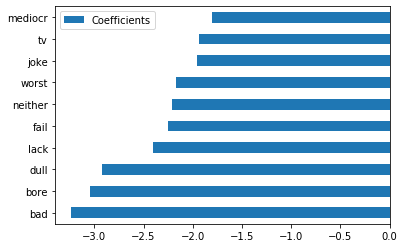

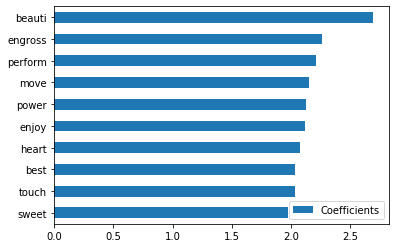

In [13]:
%%time
estimator = train(x_train, y_train, 'gs_result.csv')

In [14]:
%%time
validate(estimator, x_test, y_test)

TP:正解がPositiveで予測もPositive [[0.2807429 0.7192571]] stori surfac deep visual envelop sound blue crush make surprisingli decent flick worth summertim look see
TN:正解がNegativeで予測もNegative [[0.56444635 0.43555365]] expect get assum bar expect rais sixth grade height
TN:正解がNegativeで予測もNegative [[0.5563689 0.4436311]] empti shell epic rather real deal
TN:正解がNegativeで予測もNegative [[0.6403686 0.3596314]] distinctli sub-par like drow viewer boredom send shiver spine
TN:正解がNegativeで予測もNegative [[0.71145668 0.28854332]] anyway reason anoth crush turn dire drama partway get stupid maudlin bad thank love comed moment sever fine perform total loss
TN:正解がNegativeで予測もNegative [[0.71168772 0.28831228]] spend stuff get buck greasi littl vidgam pit theater lobbi
FP:正解がNegativeで予測はPositive [[0.35659174 0.64340826]] admir recommend overstay natur run time
TN:正解がNegativeで予測もNegative [[0.75853409 0.24146591]] chuckl least complet miss mani come amazingli lifelik tara reid act skill compar cardboard cutout
TN:正

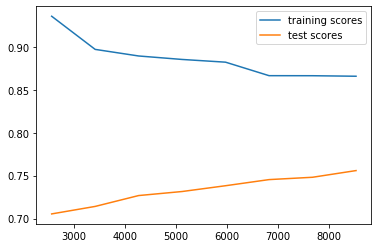

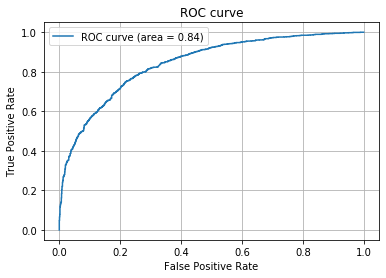

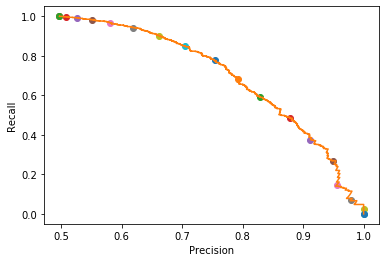

CPU times: user 26.3 s, sys: 312 ms, total: 26.6 s
Wall time: 26.8 s


In [15]:
%%time
output_graphs(estimator, x_all, y_all, x_test, y_test)